# Regression Assumptions; Quantile Regression; Loss functions

Linear regression is a nice idea, but it is based on a certain loss function, and a certain set of assumptions. In this notebook, we'll look at some ways in which violations of those asssumptions can rain on your parade.

Then, we'll introdcude a new method *quantile regression* that operates under much fewer assumptions and makes the sun shine again.

In [13]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import load_iris
from sklearn.datasets import load_boston
from sklearn import tree
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.linear_model import LinearRegression

from statsmodels.regression.quantile_regression import QuantReg 

## Demo: A nice case

Here's a simple linear regression problem, this demonstrates linear regression and looking at residual plots to determine if things have fit well.

Looking at the residual plot here, we see all the errors are fairly symmetric, with no clear pattern. The fit as well look appropriate, a line seems like a good model.

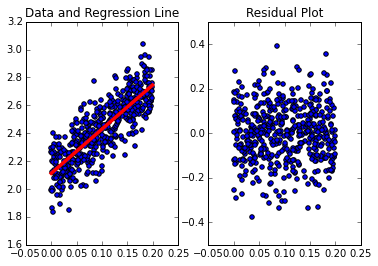

In [14]:
np.random.seed(5)

nn = 500
X_easy = np.array([np.random.rand(1) * 1. / 5 for i in range(nn)])
Y_easy = np.ravel(np.array([2 + j * 3 + np.random.normal(1) / 8.0 for j in X_easy]))

train_data_easy = X_easy[:350, :]
train_label_easy = Y_easy[:350]
test_data_easy = X_easy[350:, :]
test_label_easy = Y_easy[350:]

def PlotUnivariateFitAndResids(X, Y, preds, preds_sorted):
    plt.subplot(1, 2, 1) 
    plt.scatter(np.ravel(X), Y)
    plt.plot(np.sort(X, 0), preds_sorted, 'r', linewidth=3.5)
    plt.title("Data and Regression Line")

    plt.subplot(1, 2, 2)
    resid = np.ravel(Y) - preds
    plt.scatter(X, resid)
    plt.title("Residual Plot")

    plt.show()

## fit linear regression model
def LinearRegressionFitAndPlot(X, Y):
    lm = LinearRegression()
    lm.fit(X, Y)
    preds = lm.predict(X)
    preds_sorted = lm.predict(np.sort(X, 0))

    PlotUnivariateFitAndResids(X, Y, preds, preds_sorted)

d

## Problem 1: Non Linear Relationship

Linear regression's name gives away that it assumes a linear relationship, and if that is not the case, it is not going to do very well. Here's an example of that. Can you think of a model that would fit better?

(some things to try: http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html)

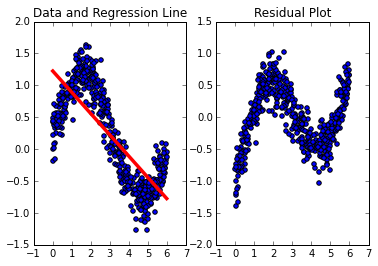

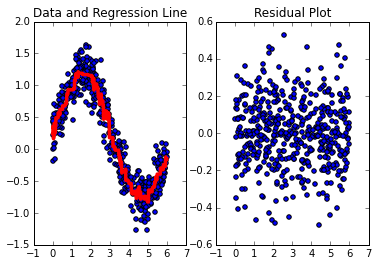

In [27]:
np.random.seed(5)

nn = 500
X_nonlin = np.array([np.random.rand(1) * 6 for i in range(nn)])
Y_nonlin = np.ravel(np.array([np.sin(j) + np.random.normal(1) / 5.0 for j in X_nonlin]))

train_data_nonlin = X_nonlin[:350, :]
train_label_nonlin = Y_nonlin[:350]
test_data_nonlin = X_nonlin[350:, :]
test_label_nonlin = Y_nonlin[350:]

LinearRegressionFitAndPlot(X_nonlin, Y_nonlin)

##
def AnotherModelFitandPlot(X, Y):
    lm = GradientBoostingRegressor(n_estimators=50) # try another model here!
    lm.fit(X, Y)
    preds = lm.predict(X)
    preds_sorted = lm.predict(np.sort(X, 0))

    PlotUnivariateFitAndResids(X, Y, preds, preds_sorted)
    
AnotherModelFitandPlot(X_nonlin, Y_nonlin)

## Problem 2: Errors not normal

Linear regression also assumes a particular type of error distribution. 

Here we've given a couple of data sets with non-normal error distributions.

Does linear regression find the true parameters here (the slope and intercept)? (1) what are the true parameters? (2) where are the estimated parameters stored in the linear regression object?

Write code to refit the linear regression, and report how well LinearRegression estimates the parameters. 

How does our ability to estimate the true model compare to the easy case?

You can compare estimates of the parameters to the true models by comparing model.coef\_ and model.intercept\_ with their known true values; in the both the easy and the case below these are 3 (slope) and 2 (intercept).

The issues with estimating the true coefficients are pretty tricky to fix in this case; we would need to know the underlying error model to do it, so that exercise is not practial.

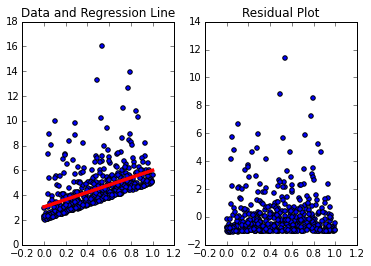

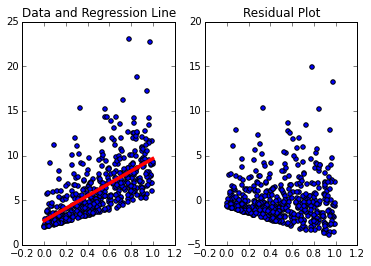

error 1 slope (truth 3):  [ 2.9514694]
error 1 inter (truth 2):  3.05591826005
error 2 slope (truth 3):  [ 6.9570871]
error 2 inter (truth 2):  2.70359178903
easy case slope (truth 3):  [ 3.16713312]
easy case inter (truth 2):  2.11231652943


In [16]:
np.random.seed(1009)

nn = 500
X_error_case_one = np.array([np.random.rand(1) for i in range(nn)])
Y_error_case_one = np.ravel(np.array([2 + 3 * j + (np.random.chisquare(1)) for j in X_error_case_one]))

X_error_case_two = np.array([np.random.rand(1) for i in range(nn)])
Y_error_case_two = np.ravel(np.array([2 + 3 * j + (np.random.chisquare(np.ceil(j * 4))) for j in X_error_case_two]))

#X_error = np.array([np.random.rand(1) for i in range(nn)])
#Y_error = np.ravel(np.array([2 + 3 * j + (np.random.chisquare(3)) for j in X_error]))

LinearRegressionFitAndPlot(X_error_case_one, Y_error_case_one)
LinearRegressionFitAndPlot(X_error_case_two, Y_error_case_two)

##
lm = LinearRegression()
lm.fit(X_error_case_one, Y_error_case_one)

print "error 1 slope (truth 3): ", lm.coef_
print "error 1 inter (truth 2): ", lm.intercept_

lm = LinearRegression()
lm.fit(X_error_case_two, Y_error_case_two)

print "error 2 slope (truth 3): ", lm.coef_
print "error 2 inter (truth 2): ", lm.intercept_

lm = LinearRegression()
lm.fit(X_easy, Y_easy)

print "easy case slope (truth 3): ", lm.coef_
print "easy case inter (truth 2): ", lm.intercept_

## An Interesting Extension: Quantile Regression

(Linear) regression can be derived from two perspectives:

1. We seek the conditional mean of the response, given the inputs; E(Y|X) [note: if we assume this conditional mean has a linear form (in terms of X), then we are doing linear regression]
2. We seek to minimize the squared error loss of a fit to the data (if we try to find the linear function that minimizes this, we are doing linear regression)

These are nice ideas and goals, but what if we want something else.

1. The mean is not a perfect statistic (is the mean a good measure of center for a skewed distribution?), what if we wanted a different measure of center, what about the median?
2. The squared error loss is nice, but what if (a) we care more about underpredicting than overpredicting, or (b) we are concerned about the influence of outliers?

*Quantile Regression* takes these alternate perspectives, and estimates the conditional quantiles of the data. This is the same as using an absolute error loss function. (Note that this loss function can be tilted to favor under or overpredicting, see: https://github.com/JohnLangford/vowpal_wabbit/wiki/Loss-functions the quantile loss in particular)

**Try using quantile regression on all the data sets generated so far.**

estimated coefficients:  [ 2.12196778  3.14332737]


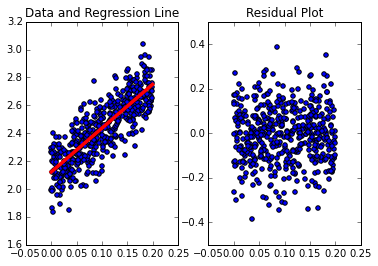

estimated coefficients:  [ 2.49747214  2.9201242 ]


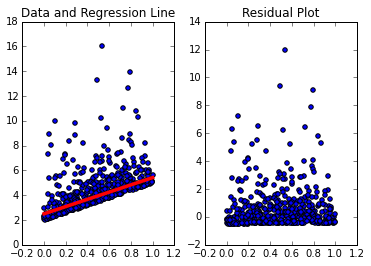

estimated coefficients:  [ 2.04529074  6.9860701 ]


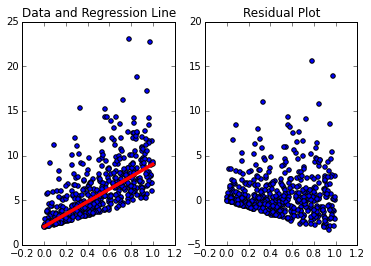

estimated coefficients:  [ 1.36084786 -0.37818539]


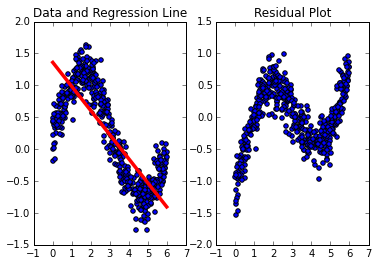

In [17]:
def QuantRegFitAndPlot(XX, YY, qq=0.5):
    # add an intercept
    XX_inter = np.hstack((XX * 0 + 1, XX))
    
    # note the differnt syntax and order of argument!!
    # this is not sklearn, sorry :(
    qr = QuantReg(YY, XX_inter) 
    qrf = qr.fit(q=qq)
    
    preds = qrf.predict(exog=XX_inter)
    preds_sorted = qrf.predict(exog=np.sort(XX_inter, 0))
    
    print "estimated coefficients: ", qrf.params 

    PlotUnivariateFitAndResids(XX, YY, preds, preds_sorted)
    
##
QuantRegFitAndPlot(X_easy, Y_easy)
QuantRegFitAndPlot(X_error_case_one, Y_error_case_one)
QuantRegFitAndPlot(X_error_case_two, Y_error_case_two)
QuantRegFitAndPlot(X_nonlin, Y_nonlin)

You should have seen that quantile regression does not work so well for the nonlinear outcome case.

We noted that quantile regression just uses a different loss function, sklearn implements different loss functions in gradientboostingregressor

http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

fit a median quantile regression model to the nonlinear data.

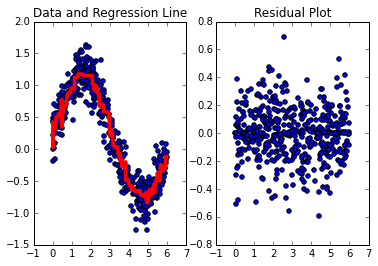

In [18]:
##
def GBQuantRegFitAndPlot(XX, YY, qq=0.5):
    # add an intercept
    gb = GradientBoostingRegressor(loss='quantile', alpha=qq)
    gb.fit(XX, YY) 
    
    preds = gb.predict(XX)
    preds_sorted = gb.predict(np.sort(XX, 0))

    PlotUnivariateFitAndResids(XX, YY, preds, preds_sorted)

GBQuantRegFitAndPlot(X_nonlin, Y_nonlin)

Now, try fitting different quantiles to the 'error' data (case two), what linear coefficients do you find for each quantile?

Compare this to the "easy" data. How does the slope and intercept parameter change with quantile here?

estimated coefficients:  [ 1.93889108  5.15791824]


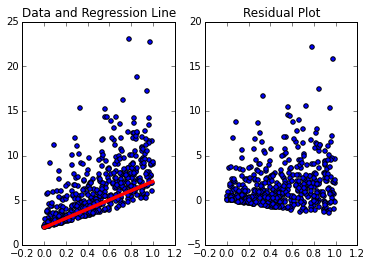

estimated coefficients:  [ 2.04529074  6.9860701 ]


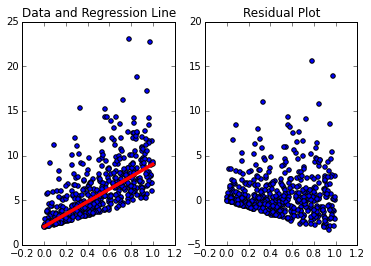

estimated coefficients:  [ 2.88039408  8.45097767]


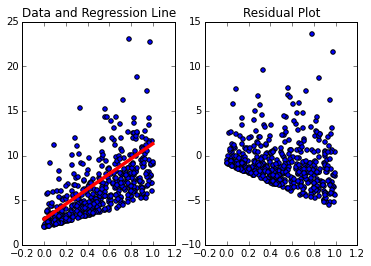

In [21]:
##
QuantRegFitAndPlot(X_error_case_two, Y_error_case_two, 0.25)
QuantRegFitAndPlot(X_error_case_two, Y_error_case_two, 0.5)
QuantRegFitAndPlot(X_error_case_two, Y_error_case_two, 0.75)

#QuantRegFitAndPlot(X_easy, Y_easy, 0.25)
#QuantRegFitAndPlot(X_easy, Y_easy, 0.5)
#QuantRegFitAndPlot(X_easy, Y_easy, 0.75)

You should see that quantile regression estimates different relationships for different quantiles of the response. This allows us to answer questions like: what is the effect of X on Y for large or small Y? (Note that here "small Y" is actually "small Y|X", meaning conditioned on the value of X)